In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Butler 

In [5]:
import lsst.daf.butler as dafButler

In [6]:
embargo = True

In [7]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [8]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

# Functions 

In [9]:
def quad(x,a,b,c):
    return a*x**2.+b*x+c

# Paths 

In [10]:
outdir_base = 'output_fits/'
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)
outdir_label = 'cyl_lens_flat_{0}/'

We check the different dimension records existing for *physical_filter*: 

In [11]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [12]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [13]:
obs_type = 'engtest'
obs_day = 20230912
physical_filter = 'cyl_lens~holo4_003' #Note that there are no exposure with this config for the moment 

In [14]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'expos','ra','dec','skyangle','science_program'])

In [15]:

where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}'".format(obs_type,obs_day,physical_filter)
#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1}".format(obs_type,obs_day)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023091200134
  physical_filter: 'cyl_lens~holo4_003'
  obs_id: 'AT_O_20230912_000134'
  exposure_time: 10.0
  dark_time: 10.2303
  observation_type: 'engtest'
  observation_reason: 'sitcom-1012'
  day_obs: 20230912
  seq_num: 134
  seq_start: 134
  seq_end: 134
  group_name: '2023-09-13T00:19:33.548'
  group_id: 2744939735480000
  target_name: 'gam Gru'
  science_program: 'BLOCK-91'
  tracking_ra: 328.48718231569546
  tracking_dec: -37.321230056170734
  sky_angle: 0.00022540061854477373
  azimuth: 112.8657960943018
  zenith_angle: 36.1493751517937
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-09-13 00:19:52.542998', scale='tai', format='iso'), end=astropy.time.Time('2023-09-13 00:20:02.774000', scale='tai', format='iso'))
	 timespan:             [2023-09-13T00:19:52.542998, 2023-09-13T00:20:02.774000)
	 timespan.begin:       2023-09-13 00:19:52.542998
	 id:                   2023091200134
	 day_obs:              2023

In [16]:
print('Number of entries = ',len(df_science))

Number of entries =  18


In [17]:
df_science

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,expos,ra,dec,skyangle,science_program
0,2023091200134,AT_O_20230912_000134,20230912,134,2023-09-13 00:19:52.542998,2023-09-13 00:20:02.774,engtest,gam Gru,cyl_lens~holo4_003,36.149375,10.0,328.487182,-37.321230,0.000225,BLOCK-91
1,2023091200137,AT_O_20230912_000137,20230912,137,2023-09-13 00:20:42.510018,2023-09-13 00:20:52.757,engtest,gam Gru,cyl_lens~holo4_003,35.983116,10.0,328.487157,-37.321226,0.000182,BLOCK-91
2,2023091200140,AT_O_20230912_000140,20230912,140,2023-09-13 00:21:26.757012,2023-09-13 00:21:36.997,engtest,gam Gru,cyl_lens~holo4_003,35.836855,10.0,328.487205,-37.321229,0.000166,BLOCK-91
3,2023091200143,AT_O_20230912_000143,20230912,143,2023-09-13 00:22:16.984017,2023-09-13 00:22:27.220,engtest,gam Gru,cyl_lens~holo4_003,35.667352,10.0,328.487308,-37.321224,0.000179,BLOCK-91
4,2023091200146,AT_O_20230912_000146,20230912,146,2023-09-13 00:23:01.244007,2023-09-13 00:23:11.482,engtest,gam Gru,cyl_lens~holo4_003,35.520941,10.0,328.487192,-37.321226,0.000156,BLOCK-91
5,2023091200149,AT_O_20230912_000149,20230912,149,2023-09-13 00:23:51.476001,2023-09-13 00:24:01.716,engtest,gam Gru,cyl_lens~holo4_003,35.354579,10.0,328.487083,-37.321230,0.000119,BLOCK-91
6,2023091200135,AT_O_20230912_000135,20230912,135,2023-09-13 00:20:10.867019,2023-09-13 00:20:21.107,engtest,gam Gru,cyl_lens~holo4_003,36.089548,10.0,328.487205,-37.321227,0.000196,BLOCK-91
7,2023091200138,AT_O_20230912_000138,20230912,138,2023-09-13 00:20:55.250001,2023-09-13 00:21:05.489,engtest,gam Gru,cyl_lens~holo4_003,35.939899,10.0,328.487166,-37.321230,0.000182,BLOCK-91
8,2023091200141,AT_O_20230912_000141,20230912,141,2023-09-13 00:21:45.333012,2023-09-13 00:21:55.567,engtest,gam Gru,cyl_lens~holo4_003,35.773674,10.0,328.487201,-37.321229,0.000181,BLOCK-91
9,2023091200144,AT_O_20230912_000144,20230912,144,2023-09-13 00:22:29.713017,2023-09-13 00:22:39.945,engtest,gam Gru,cyl_lens~holo4_003,35.627340,10.0,328.487171,-37.321230,0.000164,BLOCK-91


Select exposures: 

In [18]:
seq_nums = np.sort(np.array(df_science.seq_num))
print(seq_nums)

[133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150]


In [19]:
ids = np.sort(np.array(df_science.id))
print(ids)

[2023091200133 2023091200134 2023091200135 2023091200136 2023091200137
 2023091200138 2023091200139 2023091200140 2023091200141 2023091200142
 2023091200143 2023091200144 2023091200145 2023091200146 2023091200147
 2023091200148 2023091200149 2023091200150]


We test retrieving one of them: 

In [20]:
seq_num0 = seq_nums[0]
exp_id0 = ids[0]
print(exp_id0)

2023091200133


In [21]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

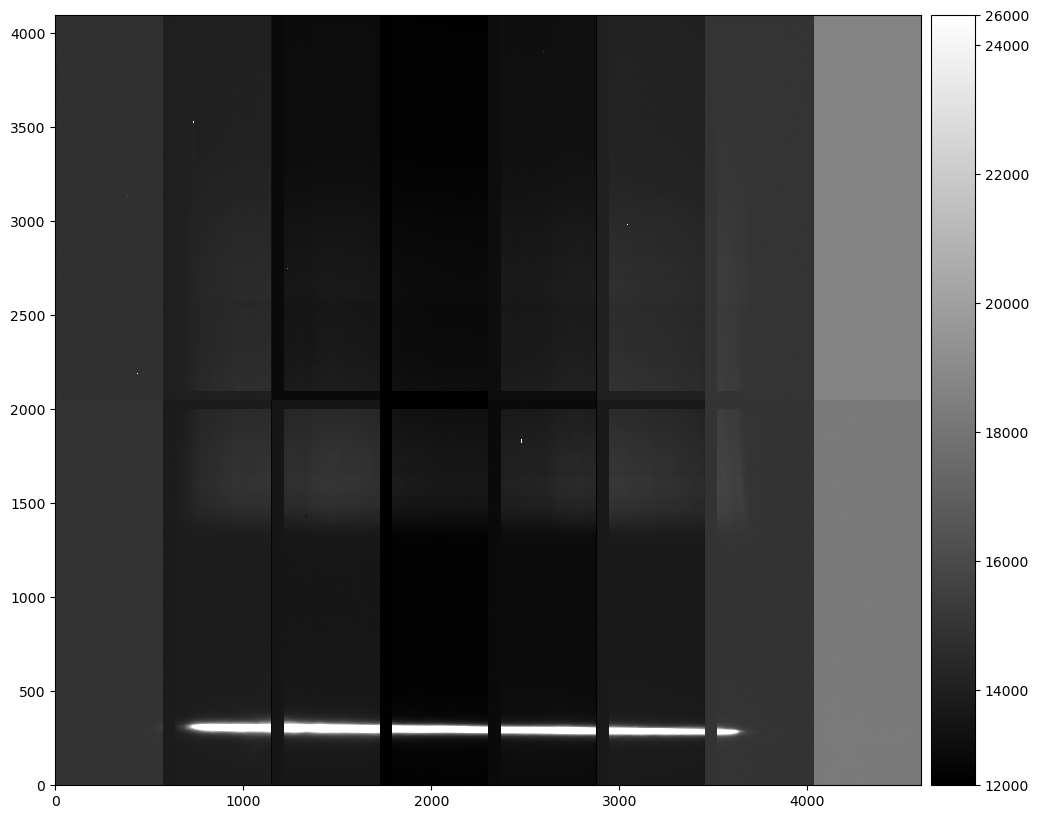

In [22]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [23]:
# configuration
isr_config =  IsrTaskConfig()

In [24]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [25]:
isr_task = IsrTask(config=isr_config)

In [26]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

In [27]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)


In [28]:
isr_test.exposure.visitInfo.getFocusZ()

-0.1266952008008957

In [29]:
isr_test.exposure.visitInfo.getId()

2023091200133

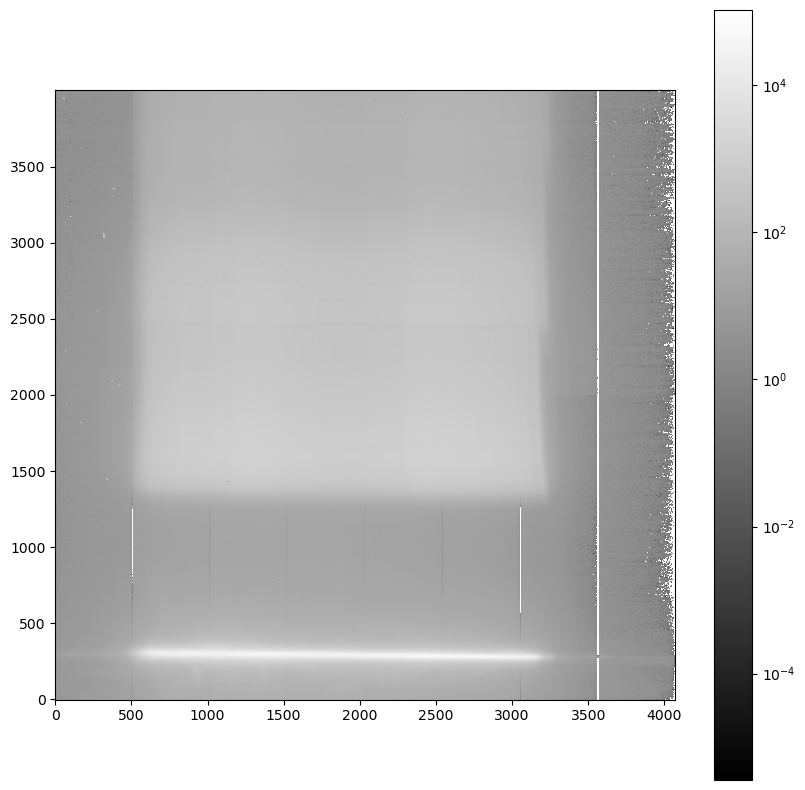

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
fig.colorbar(im,ax=ax)

# Create sum exposure from individual exposures 

## 1. Do pseudo-postISRCCD 

In [31]:
print(seq_nums)

[133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150]


In [32]:
exp_dict = {}
ampli_boxes = {}
ampli_names = []
focus_dict = {}
for i,exp_id_ in enumerate(ids):
    print(exp_id_)
    raw_img_ = butler.get('raw', dataId={'exposure': exp_id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    print('Raw image retrieved')
    
    bias_ = butler.get("bias",instrument=cameraName, exposure= exp_id_, detector=0, collections=calibCollections)
    defects_ = butler.get('defects',instrument=cameraName, exposure= exp_id_,detector=0,collections=calibCollections)
    
    #fast ISR 
    print('Running pseudo-ISR')
    isr_img_ = isr_task.run(raw_img_,bias=bias_,defects=defects_)
    
    assert (isr_img_.exposure.visitInfo.getId()==exp_id_)
    focus_ = isr_img_.exposure.visitInfo.getFocusZ()
    focus_dict[exp_id_] = focus_
    
    exp_dict[exp_id_] = isr_img_
    print('-----------------')
    
    if i==0:
        for ampIdx, amp in enumerate(raw_img_.getDetector()):
            ampli_name_ = amp.getName()
            ampli_names.append(ampli_name_)
            xbegin = amp.getBBox().x.begin
            xend = amp.getBBox().x.end
            ybegin = amp.getBBox().y.begin
            yend = amp.getBBox().y.end
            ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)
            
            md = raw_img_.getMetadata().toDict()
    

2023091200133
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200134
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200135
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200136
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200137
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200138
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200139
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200140
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200141
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200142
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200143
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200144
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200145
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200146
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200147
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200148
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200149
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200150
Raw image retrieved
Running pseudo-ISR


-----------------


In [33]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

In [34]:
mapampid = [0,1,2,3,4,5,6,7,15,14,13,12,11,10,9,8]

In [35]:
num_amplis = len(mapampid)

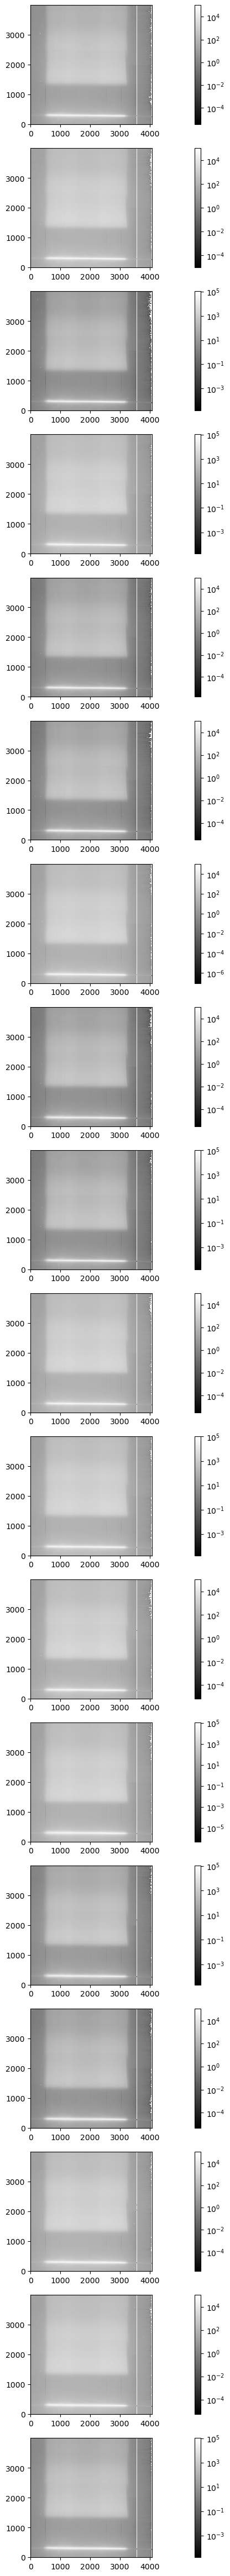

In [36]:
fig = plt.figure(figsize=(20,60))
#for i,exp_ in enumerate(exp_list):
for i,expi in enumerate(ids):
    ax = fig.add_subplot(len(ids),1,i+1)
    exp_ = exp_dict[expi]
    im = ax.imshow(exp_.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
    fig.colorbar(im,ax=ax)

In [37]:
exp0 = exp_dict[ids[0]].exposure.image.array

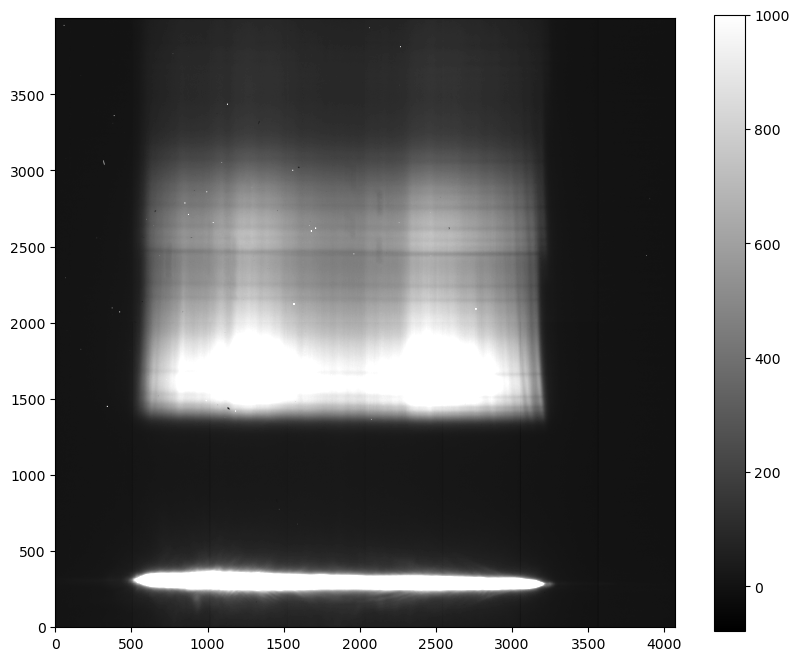

In [38]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
im = ax.imshow(exp0,cmap="gray",origin='lower',vmax=1000)#,norm=LogNorm())
fig.colorbar(im,ax=ax)

In [39]:
pos = 1750
delta_pos = 5
pmin = 200
pmax = 400
pix = np.arange(pmin,pmax)

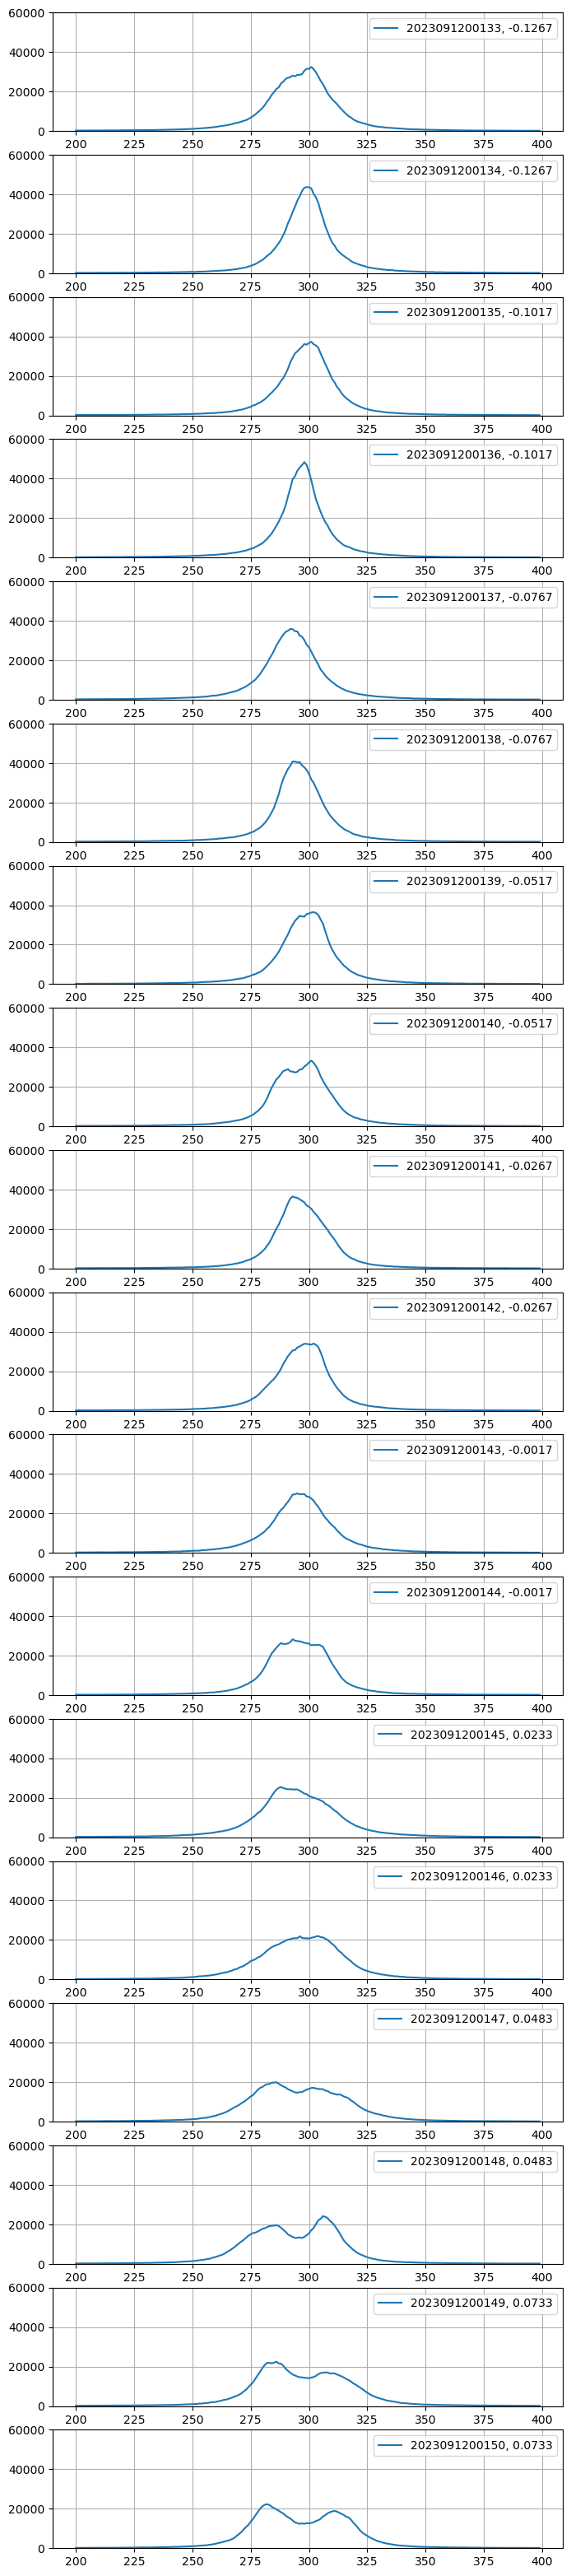

In [40]:
fig = plt.figure(figsize=(8,40))
for i,expi in enumerate(ids):
    ax = fig.add_subplot(len(ids),1,i+1)
    exp_ = exp_dict[expi].exposure.image.array
    dd_ = exp_[pmin:pmax,pos]
    focus_ = focus_dict[expi]
    ax.plot(pix,dd_,label='{0}, {1:.4f}'.format(expi,focus_))
    ax.grid()
    ax.set_ylim(0,60000)
    ax.legend()

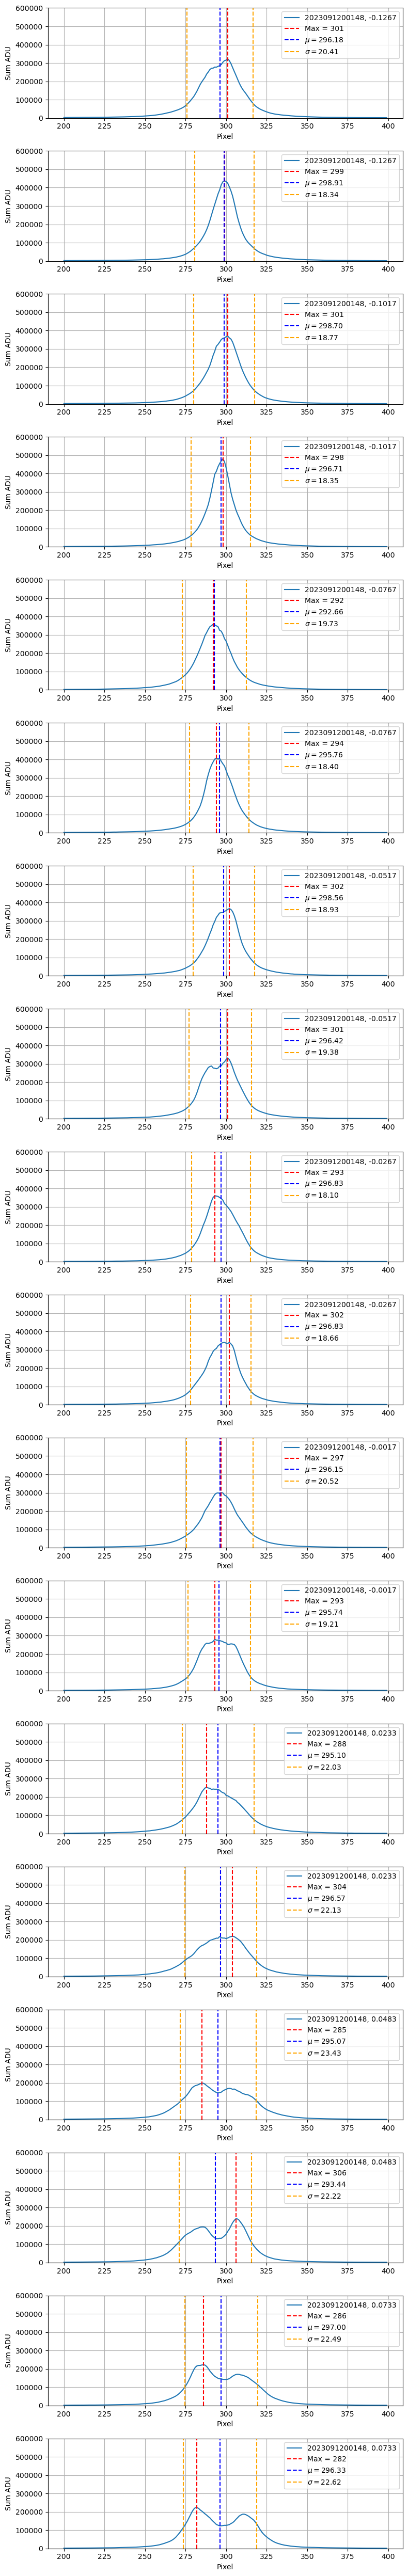

In [41]:
max_dict = {}
sigma_dict = {}
fig = plt.figure(figsize=(8,50))
for i,expi in enumerate(ids):
    ax = fig.add_subplot(len(ids),1,i+1)
    exp_ = exp_dict[expi].exposure.image.array
    dd_ = exp_[pmin:pmax,pos-delta_pos:pos+delta_pos]
    focus_ = focus_dict[expi]
    dd_sum = np.sum(dd_,axis=1)
    
    max_ = np.max(dd_sum)
    xmax_ = pix[np.where(dd_sum==max_)[0]][0]
    mu_ = np.sum(pix*dd_sum)/np.sum(dd_sum)
    sigma_ = np.sqrt(np.sum(dd_sum*(pix-mu_)**2.)/np.sum(dd_sum))
    
    max_dict[expi] = max_
    sigma_dict[expi] = sigma_
    
    ax.plot(pix,dd_sum,label='{0}, {1:.4f}'.format(id_,focus_))
    ax.axvline(x=xmax_,ls='--',color='r',label='Max = {0}'.format(xmax_))
    ax.axvline(x=mu_,ls='--',color='b',label=r'$\mu = $'+'{0:.2f}'.format(mu_))
    ax.axvline(x=mu_-sigma_,ls='--',color='orange',label=r'$\sigma = $'+'{0:.2f}'.format(sigma_))
    ax.axvline(x=mu_+sigma_,ls='--',color='orange')
    ax.set_ylim(0,600000)
    ax.grid()
    ax.set_xlabel('Pixel')
    ax.set_ylabel('Sum ADU')
    ax.legend()
plt.tight_layout()

Optimal focus from data =  -0.026695193722844124
Optimal focus from fit =  -0.07669519633054733


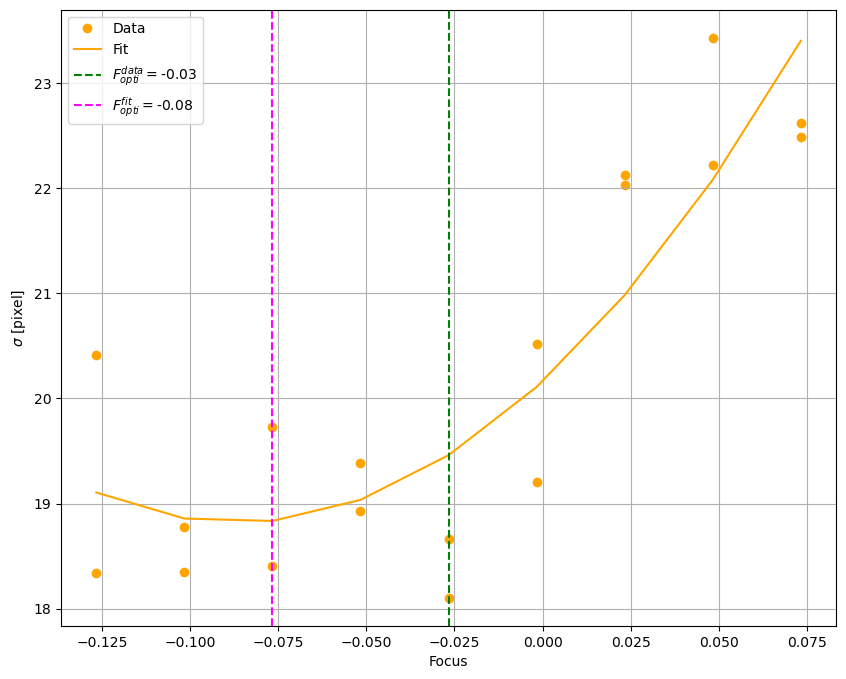

In [42]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
focus_list = []
sigma_list = []
for expi in ids:
    ax.scatter(focus_dict[expi],sigma_dict[expi],marker='o',color='orange')
    focus_list.append(focus_dict[expi])
    sigma_list.append(sigma_dict[expi])
focus_list = np.array(focus_list)
sigma_list = np.array(sigma_list)

ax.plot([],[],ls='',marker='o',color='orange',label='Data')

psigma,covsigma = curve_fit(quad,focus_list,sigma_list)

sigma_fit = quad(focus_list,psigma[0],psigma[1],psigma[2])

ax.plot(focus_list,sigma_fit,ls='-',color='orange',label='Fit')

foptdata = focus_list[np.where(sigma_list==np.min(sigma_list))[0]][0]
foptfit = focus_list[np.where(sigma_fit==np.min(sigma_fit))[0]][0]

print('Optimal focus from data = ', foptdata)
print('Optimal focus from fit = ', foptfit)

ax.axvline(x=foptdata,ls='--',color='g',label=r'$F_{opti}^{data} = $'+'{0:.2f}'.format(foptdata))
ax.axvline(x=foptfit,ls='--',color='magenta',label=r'$F_{opti}^{fit} = $'+'{0:.2f}'.format(foptfit))

ax.grid()
ax.set_xlabel('Focus')
ax.set_ylabel(r'$\sigma$ [pixel]')
ax.legend(loc="best")


[-0.0766952 -0.0766952]
-0.10169519484043121
-0.026695193722844124


Text(0, 0.5, '$\\sigma$ [pixel]')

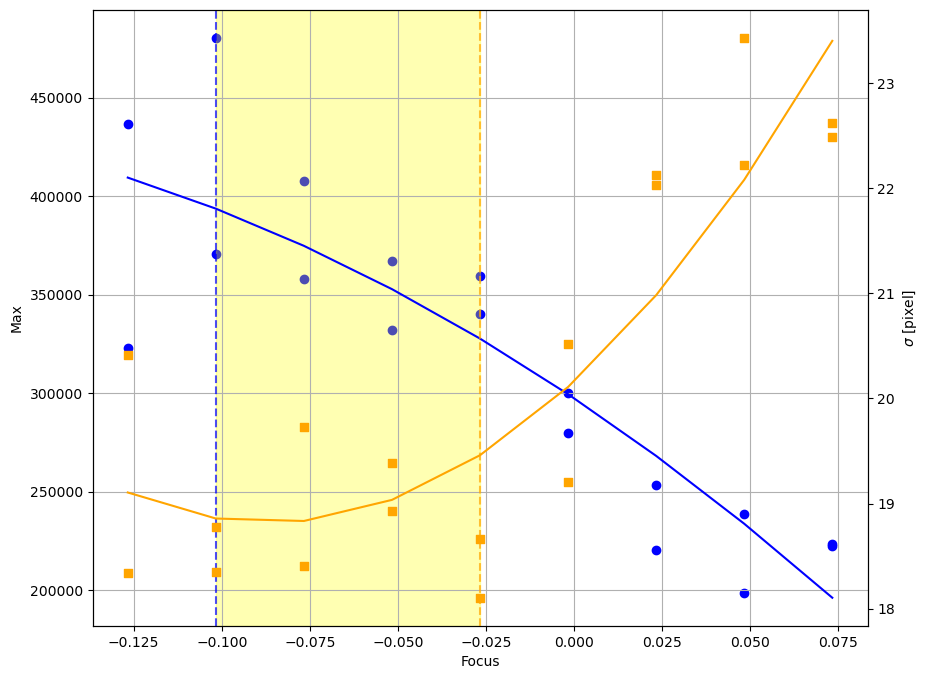

In [43]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
focus_list = []
max_list = []
sigma_list = []
for expi in ids:
    ax1.scatter(focus_dict[expi],max_dict[expi],marker='o',color='b')
    ax2.scatter(focus_dict[expi],sigma_dict[expi],marker='s',color='orange')
    focus_list.append(focus_dict[expi])
    max_list.append(max_dict[expi])
    sigma_list.append(sigma_dict[expi])
focus_list = np.array(focus_list)
max_list = np.array(max_list)
sigma_list = np.array(sigma_list)

pmax,covmax = curve_fit(quad,focus_list,max_list)
psigma,covsigma = curve_fit(quad,focus_list,sigma_list)

max_fit = quad(focus_list,pmax[0],pmax[1],pmax[2])
sigma_fit = quad(focus_list,psigma[0],psigma[1],psigma[2])

print(focus_list[np.where(sigma_fit==np.min(sigma_fit))[0]])

ax1.plot(focus_list,max_fit,ls='-',color='b')
ax2.plot(focus_list,sigma_fit,ls='-',color='orange')

fmax = focus_list[np.where(max_list==np.max(max_list))[0]][0]
fsigma = focus_list[np.where(sigma_list==np.min(sigma_list))[0]][0]

foptdata = focus_list[np.where(sigma_list==np.min(sigma_list))[0]][0]
foptfit = focus_list[np.where(sigma_fit==np.min(sigma_fit))[0]][0]

print(fmax)
print(fsigma)

ax1.axvline(x=fmax,ls='--',color='b',alpha=0.7)
ax2.axvline(x=fsigma,ls='--',color='orange',alpha=0.7)

ax1.axvspan(fmax,fsigma,color='yellow',alpha=0.3)

ax1.grid()
ax1.set_xlabel('Focus')
ax1.set_ylabel('Max')
ax2.set_ylabel(r'$\sigma$ [pixel]')
